# Convolutional Neural Network

In [7]:
import pandas as pd
from finlab.data import Data
data = Data()
twii = data.get("發行量加權股價指數")
twii = twii['台股指數']
twii = twii.resample('1D').first().dropna()

In [8]:
##t1 = indexes.tolist()
##print(indexs)

## 製作features

In [12]:
import numpy as np
import tqdm
time_period = 200

cnn_x = []
cnn_y = []
indexs = []
for i in tqdm.notebook.tqdm(range(0, len(twii) - time_period - 1 - 11, 3)):
    s = twii.iloc[i:i+time_period].values
    cnn_x.append((s - s.min())/(s.max() - s.min()))
    r = twii.iloc[i+time_period+10] / twii.iloc[i+time_period-1]
    cnn_y.append(r)
    indexs.append(twii.index[i+time_period-1])

cnn_x = np.array(cnn_x)
cnn_y = np.array(cnn_y)
indexes = np.array(indexs)




  0%|          | 0/1351 [00:00<?, ?it/s]

In [13]:
from ipywidgets import interact

@interact(x=(0, 100, 10))
def p(x=80):
    pass

interactive(children=(IntSlider(value=80, description='x', step=10), Output()), _dom_classes=('widget-interact…

## Reshape features and labels

In [14]:
cnn_x = cnn_x.reshape(len(cnn_x), time_period, 1)
cnn_y = cnn_y.reshape(len(cnn_y), 1)

## Split traning and testing data

In [15]:
import datetime
cnn_x_train = cnn_x[indexes < datetime.datetime(2021,1,1)]
cnn_y_train = cnn_y[indexes < datetime.datetime(2021,1,1)]

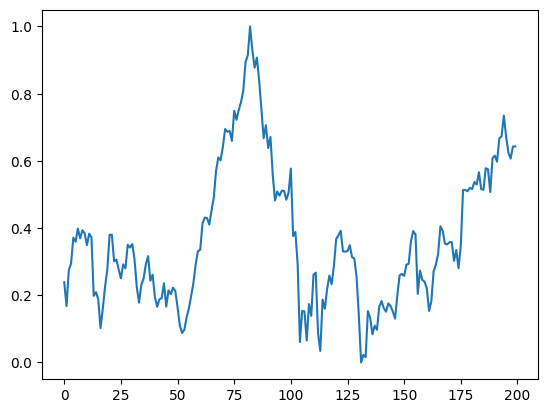

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(cnn_x[0].reshape(1, len(cnn_x[0]))[0])


## CNN

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_shape = cnn_x[0].shape
time_period = 1
num_classes = 1

model = keras.Sequential()

model.add(tf.keras.layers.Conv1D(filters=200, kernel_size=20, activation='relu', input_shape=cnn_x[0].shape))
model.add(tf.keras.layers.AveragePooling1D(5))

model.add(tf.keras.layers.Conv1D(filters=200, kernel_size=20, activation='relu'))
model.add(tf.keras.layers.AveragePooling1D(5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=120, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(units=120, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(units=84, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(units=1, ))#activation = 'softmax'))


##adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.01, amsgrad=False)
adam = keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.99, epsilon=None, amsgrad=False)


#model.compile(loss='mse',
#                optimizer=adam)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["accuracy"],
)

print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 181, 200)          4200      
                                                                 
 average_pooling1d_2 (Averag  (None, 36, 200)          0         
 ePooling1D)                                                     
                                                                 
 conv1d_3 (Conv1D)           (None, 17, 200)           800200    
                                                                 
 average_pooling1d_3 (Averag  (None, 3, 200)           0         
 ePooling1D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 600)               0         
                                                                 
 dense_4 (Dense)             (None, 120)              

In [27]:
history = model.fit(cnn_x_train, cnn_y_train,
                    batch_size=200,
                    epochs=500,
                    verbose=1,
                    validation_split=0.1,
                    #callbacks=[get_best_model]
                   )

Epoch 1/500
6/6 [==============================] - 3s 263ms/step - loss: 0.6470 - accuracy: 0.0000e+00 - val_loss: 0.3464 - val_accuracy: 0.0000e+00
Epoch 2/500
6/6 [==============================] - 2s 257ms/step - loss: 0.2623 - accuracy: 0.0000e+00 - val_loss: 0.1684 - val_accuracy: 0.0000e+00
Epoch 3/500
6/6 [==============================] - 2s 258ms/step - loss: 0.1828 - accuracy: 0.0000e+00 - val_loss: 0.0671 - val_accuracy: 0.0000e+00
Epoch 4/500
6/6 [==============================] - 2s 248ms/step - loss: 0.1180 - accuracy: 0.0000e+00 - val_loss: 0.0936 - val_accuracy: 0.0000e+00
Epoch 5/500
6/6 [==============================] - 2s 248ms/step - loss: 0.1053 - accuracy: 0.0000e+00 - val_loss: 0.0271 - val_accuracy: 0.0000e+00
Epoch 6/500
6/6 [==============================] - 2s 251ms/step - loss: 0.0853 - accuracy: 0.0000e+00 - val_loss: 0.0528 - val_accuracy: 0.0000e+00
Epoch 7/500
6/6 [==============================] - 2s 251ms/step - loss: 0.0766 - accuracy: 0.0000e+00 - v

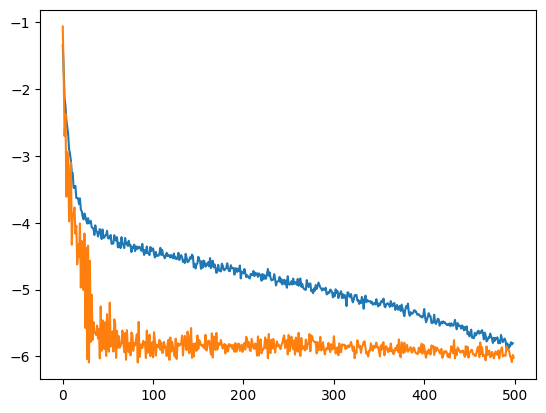

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.log(history.history['loss'][1:]))
plt.plot(np.log(history.history['val_loss']))

In [20]:
ey = model.predict(cnn_x)
ey = pd.Series(ey.swapaxes(0, 1)[0], index=indexes)

43/43 [==============================] - 0s 2ms/step


<AxesSubplot:xlabel='date'>

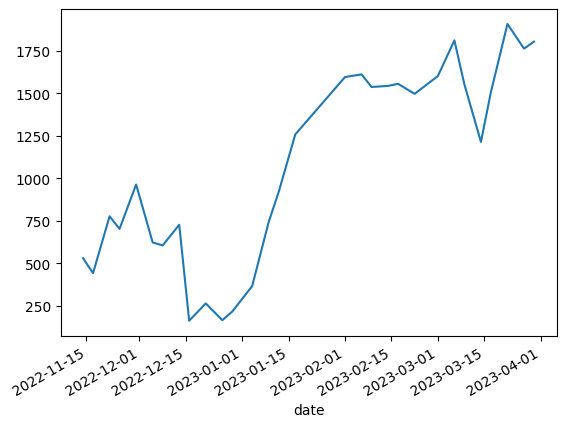

In [21]:

eq = twii[pd.to_datetime(indexes)]
gain = (eq.shift(-1) - eq)

signal = (ey > ey.quantile(0.9)).rolling(20).sum() > 0
eq = (gain[signal])['2022':].cumsum()
eq.plot()

In [22]:
signal['2022':].astype(int).diff().abs().sum()

1.0

In [23]:
eq.tail()

date
2023-03-17    1505.89
2023-03-22    1907.14
2023-03-27    1762.20
2023-03-30    1803.21
2023-04-07        NaN
Name: 台股指數, dtype: float64

In [24]:
# 預測所有日期的漲跌幅度
predicted_returns = model.predict(cnn_x)



43/43 [==============================] - 0s 2ms/step


In [25]:
import numpy as np

# 預測所有測試資料的機率
pred_probs = model.predict(cnn_x)

# 找出所有機率大於 0.5 的日期
trigger_dates = np.where(pred_probs > 0.5)[0]

# 印出觸發訊號的日期
print("Trigger dates:", trigger_dates)


43/43 [==============================] - 0s 2ms/step
Trigger dates: [   0    1    2 ... 1348 1349 1350]


In [35]:
print(indexes[-10:])

[Timestamp('2023-02-22 00:00:00') Timestamp('2023-03-01 00:00:00')
 Timestamp('2023-03-06 00:00:00') Timestamp('2023-03-09 00:00:00')
 Timestamp('2023-03-14 00:00:00') Timestamp('2023-03-17 00:00:00')
 Timestamp('2023-03-22 00:00:00') Timestamp('2023-03-27 00:00:00')
 Timestamp('2023-03-30 00:00:00') Timestamp('2023-04-07 00:00:00')]


In [40]:
import pandas as pd


# 預測股票價格
predicted_price = model.predict(cnn_x)

# 取得符合條件的日期
for i in range(len(predicted_price)):
    if predicted_price[i][0] > 0.01:  # 假設條件是價格超過 10
        print("符合條件的日期：", df.index[-len(predicted_price)+i])


43/43 [==============================] - 0s 7ms/step


NameError: name 'index' is not defined

In [39]:
predicted_price[]

array([1.0242312], dtype=float32)